In [30]:
import pandas as pd
import openpyxl
import numpy as np
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import re
import os
import sys

In [45]:
sys.path.append(os.path.join(os.getcwd(), 'Helper'))
import pmp_functions_v4 as pmp

In [90]:
# --- 1. DEFINE THE MISSING HELPER FUNCTION ---
def process_bloomberg_sheet(df, remove_header_rows=0):
    """
    Standard cleaning for Excel exports.
    1. Removes top N metadata rows.
    2. Finds the header row containing 'Date'.
    3. Resets index.
    """
    df = df.iloc[remove_header_rows:].copy()
    
    # Simple clean: Ensure we don't have empty rows at the top
    df = df.dropna(how='all')
    
    # If the first column isn't "Date", try to find the header
    # (This is a failsafe if headers are on row 3, for example)
    if "Date" not in df.columns:
        # Try to find the row that contains "Date"
        for i in range(min(10, len(df))):
            row_vals = df.iloc[i].astype(str).values
            if "Date" in row_vals:
                df.columns = df.iloc[i]
                df = df.iloc[i+1:]
                break
    
    return df


,ret_net,ret_gross,ret_bm,turnover,tcost,ret_rf,w_US_Equity,w_AU_Equity,w_CH_Equity,w_JP_Equity,...,w_US_Rates,w_EM_Rates,w_UK_Rates,w_JP_Rates,w_CH_FX,w_EU_FX,w_JP_FX,w_UK_FX,w_AU_FX,w_EM_FX
Date,,,,,,,,,,,,,,,,,,,,,
1989-03-31,0.002958,0.002958,0.000000,0.000000,0.000000,0.001667,-1.0,0.038285,0.038285,0.038285,...,0.038285,0.038285,0.038285,0.038285,0.040891,0.038285,0.040149,0.039470,0.037214,0.038285
1989-04-30,0.000552,0.000907,0.000000,0.354747,0.000355,0.001667,-1.0,0.038407,0.038407,0.038407,...,0.038407,0.038407,0.038407,0.038407,0.038774,0.038407,0.038645,0.038222,0.039394,0.038407
1989-05-31,0.004827,0.005182,0.000000,0.354747,0.000355,0.001667,-1.0,0.038153,0.038153,0.038153,...,0.038153,0.038153,0.038153,0.038153,0.039010,0.038153,0.040872,0.040794,0.039964,0.038153
1989-06-30,-0.000342,0.000013,0.000000,0.354747,0.000355,0.001667,-1.0,0.038461,0.038461,0.038461,...,0.038461,0.038461,0.038461,0.038461,0.037963,0.038461,0.039062,0.038810,0.038029,0.038461
1989-07-31,-0.004923,-0.004568,0.000000,0.354747,0.000355,0.001667,-1.0,0.038734,0.038734,0.038734,...,0.038734,0.038734,0.038734,0.038734,0.037059,0.038734,0.036898,0.035691,0.038206,0.038734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,0.034815,0.036460,0.043488,1.645253,0.001645,0.001667,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-07-31,-0.026405,-0.024760,0.013121,1.645253,0.001645,0.001667,0.0,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
2025-08-31,0.025221,0.026866,0.026408,1.645253,0.001645,0.001667,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000


Loading Equities...

--- RUNNING STRATEGY: EQUITY ---
   Assets: 7
   Realized Vol (Unscaled): 24.53%
   Scaling Factor: 0.41x

Loading Bonds...

--- RUNNING STRATEGY: BOND ---
   Assets: 7
   Realized Vol (Unscaled): 10.36%
   Scaling Factor: 0.96x

Loading Rates...

--- RUNNING STRATEGY: RATES ---
   Assets: 7
   Realized Vol (Unscaled): 1.69%
   Scaling Factor: 3.00x

Loading FX...

--- RUNNING STRATEGY: FX ---
   Assets: 6
   Realized Vol (Unscaled): 11.94%
   Scaling Factor: 0.84x

Final Portfolio Re-Scaling Factor: 1.87x

             PERFORMANCE SUMMARY PER ASSET CLASS       
                          Equity     Bond    Rates       FX  Total_Portfolio
Arithm Avg Total Return  -6.3721   0.4186  -2.2081   0.3716          -3.6396
Arithm Avg Xs Return     -8.3721  -1.5814  -4.2081  -1.6284          -5.6396
Std Xs Returns           10.0017  10.1110   5.0749   9.7826          10.0000
Sharpe Arithmetic        -0.8371  -0.1564  -0.8292  -0.1665          -0.5640
Geom Avg Total Return    

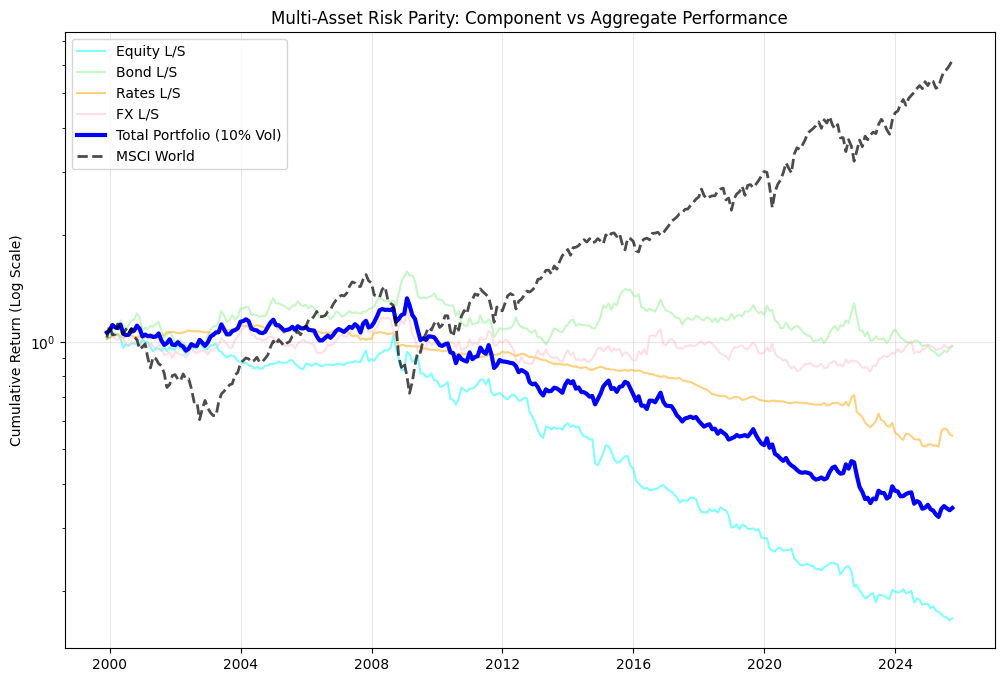

In [85]:


# --- CONFIGURATION ---
VOL_TARGET = 0.10
data_path = '../Data/'

# =============================================================================
# 1. THE STRATEGY FACTORY
# =============================================================================
def run_independent_strategy(name, df_prices, k_select=1, min_assets=4):
    """
    Runs a complete, isolated Momentum L/S strategy for a single asset class.
    """
    print(f"\n--- RUNNING STRATEGY: {name} ---")
    print(f"   Assets: {len(df_prices.columns)}")
    
    # A. Prepare Data
    returns = df_prices.pct_change().fillna(0)
    rf_series = pd.Series(0.02/12, index=returns.index, name="RF")
    dummy_benchmark = returns.mean(axis=1) 
    
    # B. Signal Generation
    lookbacks = [1, 3, 12]
    raw_signal = pd.DataFrame(0.0, index=df_prices.index, columns=df_prices.columns)
    
    for lag in lookbacks:
        mom = df_prices.pct_change(lag)
        sig = mom
        raw_signal += sig
    
    final_signal = raw_signal / len(lookbacks)
    
    # C. Weight Generation
    weights = pmp.make_country_weights(
        signal=final_signal,
        returns=returns,
        benchmark_series=dummy_benchmark,
        k=k_select,            
        long_short=True,
        beta_neutral=False,    
        signal_lag=1,
        min_regions=min_assets 
    )
    
    # D. Preliminary Backtest (Unscaled)
    res_unscaled = pmp.run_cc_strategy(
        weights=weights,
        returns=returns,
        rf=rf_series,
        frequency=1,
        t_cost=0.0, 
        benchmark="equal", 
        long_short=True,
        beta_neutral=False
    )
    
    # E. Volatility Targeting
    ret_series = res_unscaled["ret_net"].dropna()
    realized_vol = ret_series.std() * np.sqrt(12)
    
    if realized_vol > 0:
        scalar = VOL_TARGET / realized_vol
        scalar = min(scalar, 3.0) 
    else:
        scalar = 1.0
        
    print(f"   Realized Vol (Unscaled): {realized_vol:.2%}")
    print(f"   Scaling Factor: {scalar:.2f}x")
    
    # F. Final Scaled Backtest
    weights_scaled = weights * scalar
    res_final = pmp.run_cc_strategy(
        weights=weights_scaled,
        returns=returns,
        rf=rf_series,
        frequency=1,
        t_cost=0.0010, 
        benchmark="equal", 
        long_short=True,
        beta_neutral=False
    )
    
    return res_final["ret_net"]

# =============================================================================
# 2. RUNNING ASSET CLASSES INDEPENDENTLY
# =============================================================================

# --- A. EQUITIES ---
print("Loading Equities...")
df_eq = pd.read_excel(os.path.join(data_path, "Equity Data.xlsx"), engine='openpyxl')
if 'Date' in df_eq.columns: df_eq = df_eq.set_index('Date')
else: df_eq = df_eq.set_index(df_eq.columns[0])
df_eq.index = pd.to_datetime(df_eq.index, errors='coerce')
df_eq.columns = [f"{c}_Eq" for c in df_eq.columns]
df_eq = df_eq.apply(pd.to_numeric, errors='coerce').resample("ME").last().ffill()

ret_equity = run_independent_strategy("EQUITY", df_eq, k_select=1, min_assets=4)

# --- B. BONDS ---
print("\nLoading Bonds...")
df_bd = pd.read_excel(os.path.join(data_path, "Bond Data.xlsx"), engine='openpyxl')
if 'Dates' in df_bd.columns: df_bd = df_bd.set_index('Dates')
else: df_bd = df_bd.set_index(df_bd.columns[0])
df_bd.index = pd.to_datetime(df_bd.index, errors='coerce')
df_bd.columns = [f"{c}_Bd" for c in df_bd.columns]
df_bd = df_bd.apply(pd.to_numeric, errors='coerce').resample("ME").last().ffill()

ret_bond = run_independent_strategy("BOND", df_bd, k_select=1, min_assets=4)

# --- C. RATES ---
print("\nLoading Rates...")
df_rt = pd.read_excel(os.path.join(data_path, "Interest Rates Data.xlsx"), engine='openpyxl')
if 'Date' in df_rt.columns: df_rt = df_rt.set_index('Date')
else: df_rt = df_rt.set_index(df_rt.columns[0])
df_rt.index = pd.to_datetime(df_rt.index, errors='coerce')
df_rt.columns = [f"{c}_Rt" for c in df_rt.columns]
df_rt = df_rt.apply(pd.to_numeric, errors='coerce').resample("ME").last().ffill()

ret_rates = run_independent_strategy("RATES", df_rt, k_select=1, min_assets=4)

# --- D. FX ---
print("\nLoading FX...")
df_fx_ret = pd.read_excel(os.path.join(data_path, "FX Data.xlsx"), sheet_name="RETURNS", engine='openpyxl')
if 'Date' in df_fx_ret.columns: df_fx_ret = df_fx_ret.set_index('Date')
else: df_fx_ret = df_fx_ret.set_index(df_fx_ret.columns[0])
df_fx_ret.index = pd.to_datetime(df_fx_ret.index, errors='coerce')
df_fx = (1 + df_fx_ret.fillna(0)).cumprod() * 100
df_fx.columns = [f"{c}_FX" for c in df_fx.columns]
df_fx = df_fx.resample("ME").last().ffill()

ret_fx = run_independent_strategy("FX", df_fx, k_select=1, min_assets=4)

# =============================================================================
# 3. AGGREGATION
# =============================================================================

# Combine Strategies
df_strategies = pd.DataFrame({
    'Equity': ret_equity,
    'Bond': ret_bond,
    'Rates': ret_rates,
    'FX': ret_fx
}).dropna()

# Portfolio Construction (Risk Parity / Equal Weight)
final_portfolio_ret = df_strategies.mean(axis=1)

# Re-Scale to Target Vol
port_vol = final_portfolio_ret.std() * np.sqrt(12)
final_scalar = VOL_TARGET / port_vol if port_vol > 0 else 1.0
final_scalar = min(final_scalar, 2.0)
final_portfolio_ret = final_portfolio_ret * final_scalar

print(f"\nFinal Portfolio Re-Scaling Factor: {final_scalar:.2f}x")

# =============================================================================
# 4. SUMMARY PER ASSET CLASS
# =============================================================================

# Load Benchmark
df_bench = pd.read_excel(os.path.join(data_path, "Benchmarks.xlsx"), engine='openpyxl')
if 'Date' in df_bench.columns: df_bench = df_bench.set_index('Date')
else: df_bench = df_bench.set_index(df_bench.columns[0])
df_bench.index = pd.to_datetime(df_bench.index, errors='coerce')
df_bench = df_bench.resample("ME").last().ffill()
benchmark_ret = df_bench['MSCI World'].pct_change().fillna(0)

# Create Consolidated Dataframe for Summary
df_all = df_strategies.copy()
df_all['Total_Portfolio'] = final_portfolio_ret

# Align everything
common_idx = df_all.index.intersection(benchmark_ret.index)
df_all = df_all.loc[common_idx]
bm_aligned = benchmark_ret.loc[common_idx]
rf_aligned = pd.Series(0.02/12, index=common_idx)

# Calculate Excess Returns
xs_all = df_all.sub(rf_aligned, axis=0)
xs_bench = (bm_aligned - rf_aligned).to_frame()

print("\n=======================================================")
print("             PERFORMANCE SUMMARY PER ASSET CLASS       ")
print("=======================================================")

summary = pmp.summarizePerformance(
    xsReturns=xs_all.values,
    Rf=rf_aligned.values.reshape(-1, 1),
    factorXsReturns=xs_bench.values, 
    annualizationFactor=12,
    strategyNames=df_all.columns.tolist()
)

print(summary)

# Correlation Matrix
print("\n--- Correlation Matrix ---")
print(df_all.corr().round(2))

# =============================================================================
# 5. VISUALIZATION
# =============================================================================
cum_all = (1 + df_all).cumprod()
cum_bench = (1 + bm_aligned).cumprod()

plt.figure(figsize=(12, 8))
colors = ['cyan', 'lightgreen', 'orange', 'pink']

# Plot Components
for i, col in enumerate(df_strategies.columns):
    plt.plot(cum_all[col], label=f"{col} L/S", alpha=0.5, linewidth=1.5, color=colors[i])

# Plot Total & Benchmark
plt.plot(cum_all['Total_Portfolio'], label="Total Portfolio (10% Vol)", color="blue", linewidth=3)
plt.plot(cum_bench, label="MSCI World", color="black", linestyle="--", linewidth=2, alpha=0.7)

plt.title("Multi-Asset Risk Parity: Component vs Aggregate Performance")
plt.ylabel("Cumulative Return (Log Scale)")
plt.yscale("log")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [74]:
ret_equity

Date
1997-11-30   -0.017056
1997-12-31   -0.008867
1998-01-31    0.004354
1998-02-28   -0.019868
1998-03-31   -0.020761
                ...   
2025-05-31   -0.012518
2025-06-30   -0.016222
2025-07-31   -0.012988
2025-08-31   -0.015610
2025-09-30    0.012118
Name: ret_net, Length: 335, dtype: float64

Loading Equities...
Loading Bonds...
Loading Rates...
Loading FX...
Loading Benchmark...
Processing Equities...
   Realized Vol: 5.30%
   Scaler: 1.89x
Processing Bonds...
   Realized Vol: 4.02%
   Scaler: 2.00x
Processing Rates...
   Realized Vol: 1.10%
   Scaler: 2.00x
Processing FX...
   Realized Vol: 4.08%
   Scaler: 2.00x

Final Portfolio Volatility: 10.00%

             AQR TIME SERIES MOMENTUM - PERFORMANCE SUMMARY
                          Equity     Bond    Rates       FX  Total_Portfolio
Arithm Avg Total Return   2.0131  -0.0365  -2.8946   1.2438           0.1538
Arithm Avg Xs Return      0.0131  -2.0365  -4.8946  -0.7562          -1.8462
Std Xs Returns           10.0597   8.0432   2.1991   8.8406          10.0000
Sharpe Arithmetic         0.0013  -0.2532  -2.2258  -0.0855          -0.1846
Geom Avg Total Return     1.5277  -0.3568  -2.8799   0.8590          -0.3344
Geom Avg Xs Return       -0.4907  -2.3753  -4.8983  -1.1594          -2.3529
Sharpe Geometric         -0.0488  -

/var/folders/p9/l40tvhkx4mgfss50nv3s08w80000gn/T/ipykernel_6810/666962033.py:192: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vol = vol.replace(0, np.nan).fillna(method='ffill').fillna(0.10)
/var/folders/p9/l40tvhkx4mgfss50nv3s08w80000gn/T/ipykernel_6810/666962033.py:192: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vol = vol.replace(0, np.nan).fillna(method='ffill').fillna(0.10)
/var/folders/p9/l40tvhkx4mgfss50nv3s08w80000gn/T/ipykernel_6810/666962033.py:192: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vol = vol.replace(0, np.nan).fillna(method='ffill').fillna(0.10)
/var/folders/p9/l40tvhkx4mgfss50nv3s08w80000gn/T/ipykernel_6810/666962033.py:192: FutureWarning: DataFrame.fillna with 'method' is deprecated and

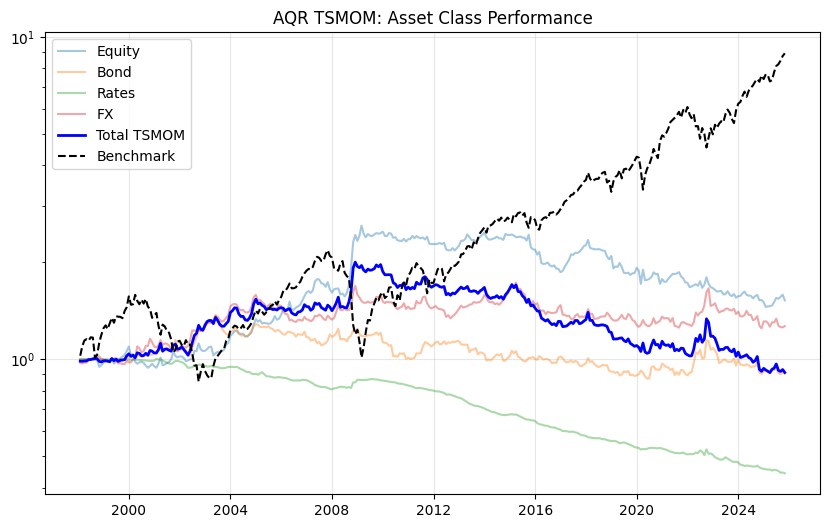


--- Correlation Matrix ---
                 Equity  Bond  Rates    FX  Total_Portfolio
Equity             1.00  0.22   0.26  0.31             0.72
Bond               0.22  1.00   0.33  0.53             0.74
Rates              0.26  0.33   1.00  0.22             0.45
FX                 0.31  0.53   0.22  1.00             0.79
Total_Portfolio    0.72  0.74   0.45  0.79             1.00


In [88]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import skew, kurtosis

# --- CONFIGURATION ---
VOL_TARGET = 0.10
data_path = '../Data/'

# =============================================================================
# 0. HELPER FUNCTION: SUMMARIZE PERFORMANCE
# (Included directly to ensure consistent output format)
# =============================================================================
def summarizePerformance(xsReturns, Rf, factorXsReturns, annualizationFactor, strategyNames):
    # Ensure inputs are 2D arrays
    if xsReturns.ndim == 1: xsReturns = xsReturns.reshape(-1, 1)
    if Rf.ndim == 1: Rf = Rf.reshape(-1, 1)
    if factorXsReturns.ndim == 1: factorXsReturns = factorXsReturns.reshape(-1, 1)

    nPeriods = xsReturns.shape[0]
    nAssets = xsReturns.shape[1]
    nFactors = factorXsReturns.shape[1]
    totalReturns = xsReturns + Rf

    # Geometric Stats
    FinalPfValRf = np.prod(1 + Rf, axis=0)
    FinalPfValTotalRet = np.prod(1 + totalReturns, axis=0)
    GeomAvgRf = 100 * (FinalPfValRf**(annualizationFactor / nPeriods) - 1)
    GeomAvgTotalReturn = 100 * (FinalPfValTotalRet**(annualizationFactor / nPeriods) - 1)
    GeomAvgXsReturn = GeomAvgTotalReturn - GeomAvgRf

    # Regression Stats (Alpha/Beta)
    alphaArithmetic = np.zeros((1, nAssets))
    alphaPVal = np.zeros((1, nAssets))
    betas = np.zeros((nFactors, nAssets))
    betasPVal = np.zeros((nFactors, nAssets))
    trackingError = np.zeros((1, nAssets))

    x = sm.add_constant(factorXsReturns)
    for asset in range(nAssets):
        y = xsReturns[:, asset]
        # Handle cases with too few data points or NaNs
        valid_idx = ~np.isnan(y) & ~np.isnan(x).any(axis=1)
        if np.sum(valid_idx) > 10:
            model = sm.OLS(y[valid_idx], x[valid_idx]).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
            alphaArithmetic[0, asset] = 100 * annualizationFactor * model.params[0]
            alphaPVal[0, asset] = model.pvalues[0]
            betas[:, asset] = model.params[1:]
            betasPVal[:, asset] = model.pvalues[1:]
            trackingError[0, asset] = 100 * np.sqrt(annualizationFactor) * np.sqrt(model.mse_resid)

    # Geometric Alpha
    if nFactors > 0:
        bmRet = factorXsReturns @ betas + Rf
        FinalPfValBm = np.prod(1 + bmRet, axis=0)
        GeomAvgBmReturn = 100 * (FinalPfValBm**(annualizationFactor / nPeriods) - 1)
        alphaGeometric = GeomAvgTotalReturn - GeomAvgBmReturn
    else:
        alphaGeometric = np.zeros(nAssets)

    # Arithmetic Stats
    xsReturnsPct = xsReturns * 100
    totalReturnsPct = totalReturns * 100
    ArithmAvgTotalReturn = annualizationFactor * np.mean(totalReturnsPct, axis=0)
    ArithmAvgXsReturn = annualizationFactor * np.mean(xsReturnsPct, axis=0)
    StdXsReturns = np.sqrt(annualizationFactor) * np.std(xsReturnsPct, axis=0, ddof=1)
    
    # Sharpe (prevent div by zero)
    with np.errstate(divide='ignore', invalid='ignore'):
        SharpeArithmetic = np.where(StdXsReturns!=0, ArithmAvgXsReturn / StdXsReturns, 0)
        SharpeGeometric = np.where(StdXsReturns!=0, GeomAvgXsReturn / StdXsReturns, 0)

    MinXsReturn = np.min(xsReturnsPct, axis=0)
    MaxXsReturn = np.max(xsReturnsPct, axis=0)
    SkewXsReturn = skew(xsReturnsPct, axis=0)
    KurtXsReturn = kurtosis(xsReturnsPct, axis=0)

    # Build Table
    rows = ['Arithm Avg Total Return', 'Arithm Avg Xs Return', 'Std Xs Returns', 'Sharpe Arithmetic',
            'Geom Avg Total Return', 'Geom Avg Xs Return', 'Sharpe Geometric', 'Min Xs Return', 'Max Xs Return',
            'Skewness', 'Excess Kurtosis', 'Alpha Arithmetic', 'Alpha Arithmetic p-val', 'Alpha Geometric']
    for i in range(nFactors):
        rows.append(f'Beta {i+1}')
        rows.append(f'Beta {i+1} p-val')
    rows += ['Tracking Error', 'Information Ratio']

    data = [ArithmAvgTotalReturn, ArithmAvgXsReturn, StdXsReturns, SharpeArithmetic,
            GeomAvgTotalReturn, GeomAvgXsReturn, SharpeGeometric, MinXsReturn, MaxXsReturn,
            SkewXsReturn, KurtXsReturn, alphaArithmetic, alphaPVal, alphaGeometric]
    for i in range(nFactors):
        data.append(betas[i, :])
        data.append(betasPVal[i, :])
    
    # Safe division for Info Ratio
    InfoRatio = np.zeros_like(alphaGeometric)
    non_zero_te = trackingError[0] != 0 # Check tracking error array
    InfoRatio[non_zero_te] = alphaGeometric[non_zero_te] / trackingError[0][non_zero_te]
    
    data += [trackingError, InfoRatio]

    df = pd.DataFrame(np.vstack(data), index=rows, columns=strategyNames)
    return df.round(4)

# =============================================================================
# 1. DATA LOADING
# =============================================================================
# Equity
print("Loading Equities...")
try:
    df_eq = pd.read_excel(os.path.join(data_path, "Equity Data.xlsx"), engine='openpyxl')
except FileNotFoundError:
    df_eq = pd.read_csv("Futures.xlsx - Data.csv") # Fallback
    
if 'Date' in df_eq.columns: df_eq = df_eq.set_index('Date')
else: df_eq = df_eq.set_index(df_eq.columns[0])
df_eq.index = pd.to_datetime(df_eq.index, errors='coerce')
df_eq.columns = [f"{c}_Eq" for c in df_eq.columns]
df_eq = df_eq.apply(pd.to_numeric, errors='coerce').resample("ME").last().ffill()

# Bonds
print("Loading Bonds...")
try:
    df_bd = pd.read_excel(os.path.join(data_path, "Bond Data.xlsx"), engine='openpyxl')
except:
    df_bd = pd.read_csv("Bond Futures.xlsx - Sheet1.csv")
    
if 'Dates' in df_bd.columns: df_bd = df_bd.set_index('Dates')
else: df_bd = df_bd.set_index(df_bd.columns[0])
df_bd.index = pd.to_datetime(df_bd.index, errors='coerce')
df_bd.columns = [f"{c}_Bd" for c in df_bd.columns]
df_bd = df_bd.apply(pd.to_numeric, errors='coerce').resample("ME").last().ffill()

# Rates
print("Loading Rates...")
try:
    df_rt = pd.read_excel(os.path.join(data_path, "Interest Rates Data.xlsx"), engine='openpyxl')
except:
    df_rt = pd.read_csv("Interest Rates Data.xlsx - Sheet1.csv")

if 'Date' in df_rt.columns: df_rt = df_rt.set_index('Date')
else: df_rt = df_rt.set_index(df_rt.columns[0])
df_rt.index = pd.to_datetime(df_rt.index, errors='coerce')
df_rt.columns = [f"{c}_Rt" for c in df_rt.columns]
df_rt = df_rt.apply(pd.to_numeric, errors='coerce').resample("ME").last().ffill()

# FX (Hedged Returns -> Price Index)
print("Loading FX...")
try:
    df_fx_ret = pd.read_excel(os.path.join(data_path, "FX Data.xlsx"), sheet_name="HEDGE RETURN", engine='openpyxl')
except:
    df_fx_ret = pd.read_csv("FX Data.xlsx - HEDGE RETURN.csv")

if 'Date' in df_fx_ret.columns: df_fx_ret = df_fx_ret.set_index('Date')
else: df_fx_ret = df_fx_ret.set_index(df_fx_ret.columns[0])
df_fx_ret.index = pd.to_datetime(df_fx_ret.index, errors='coerce')
# Convert Returns to Price Index
df_fx = (1 + df_fx_ret.fillna(0)).cumprod() * 100
df_fx.columns = [f"{c}_FX" for c in df_fx.columns]
df_fx = df_fx.resample("ME").last().ffill()

# Benchmark
print("Loading Benchmark...")
try:
    df_bench = pd.read_excel(os.path.join(data_path, "Benchmarks.xlsx"), engine='openpyxl')
except:
    df_bench = pd.read_csv("Benchmarks.xlsx - Benchmarks.csv")

if 'Date' in df_bench.columns: df_bench = df_bench.set_index('Date')
else: df_bench = df_bench.set_index(df_bench.columns[0])
df_bench.index = pd.to_datetime(df_bench.index, errors='coerce')
df_bench = df_bench.resample("ME").last().ffill()
benchmark_ret = df_bench['MSCI World'].pct_change().fillna(0)

# =============================================================================
# 2. AQR TSMOM LOGIC
# =============================================================================

def run_aqr_strategy(name, df_prices):
    """
    Implements AQR Time Series Momentum.
    1. Vol Estimation (36m rolling)
    2. Trend Signal (Avg of 1m, 3m, 12m signs)
    3. Vol Scaling (Weight = Target / Vol)
    """
    print(f"Processing {name}...")
    returns = df_prices.pct_change().fillna(0)
    
    # 1. Ex-ante Volatility (floor to avoid infinity)
    vol = returns.rolling(36).std() * np.sqrt(12)
    vol = vol.replace(0, np.nan).fillna(method='ffill').fillna(0.10)
    
    # 2. Trend Signals
    s1 = np.sign(df_prices.pct_change(1))
    s3 = np.sign(df_prices.pct_change(3))
    s12 = np.sign(df_prices.pct_change(12))
    composite_signal = (s1 + s3 + s12) / 3.0
    
    # 3. Position Sizing (Risk Parity)
    target_weights = composite_signal.div(vol, axis=0) * VOL_TARGET
    # Cap single asset leverage at 4x
    target_weights = target_weights.clip(-4, 4)
    
    # 4. Lag & Execute
    weights = target_weights.shift(1).fillna(0)
    # Transaction costs (approx 10bps)
    turnover = weights.diff().abs().mean(axis=1).fillna(0)
    costs = turnover * 0.0010 
    
    # Equal Weight across assets in this class
    strat_ret = (weights * returns).mean(axis=1) - costs
    
    # 5. Vol Target the Strategy
    realized_vol = strat_ret.std() * np.sqrt(12)
    scaler = VOL_TARGET / realized_vol if realized_vol > 0 else 0
    scaler = min(scaler, 2.0) # Cap strategy leverage
    
    print(f"   Realized Vol: {realized_vol:.2%}")
    print(f"   Scaler: {scaler:.2f}x")
    
    return strat_ret * scaler

# =============================================================================
# 3. RUN STRATEGIES & AGGREGATE
# =============================================================================

ret_eq = run_aqr_strategy("Equities", df_eq)
ret_bd = run_aqr_strategy("Bonds", df_bd)
ret_rt = run_aqr_strategy("Rates", df_rt)
ret_fx = run_aqr_strategy("FX", df_fx)

# Combine
df_strats = pd.DataFrame({
    'Equity': ret_eq,
    'Bond': ret_bd,
    'Rates': ret_rt,
    'FX': ret_fx
}).dropna()

# Final Portfolio (Equal Risk Contribution)
# Since each is 10% Vol, this is an Equal Risk Contribution portfolio.
port_ret = df_strats.mean(axis=1)

# Rescale Final Portfolio to Target Vol
total_vol = port_ret.std() * np.sqrt(12)
final_scaler = VOL_TARGET / total_vol if total_vol > 0 else 1.0
final_scaler = min(final_scaler, 2.0)
port_ret = port_ret * final_scaler

print(f"\nFinal Portfolio Volatility: {port_ret.std()*np.sqrt(12):.2%}")

# =============================================================================
# 4. OUTPUT SUMMARY
# =============================================================================

# Align Data for Summary
df_all = df_strats.copy()
df_all['Total_Portfolio'] = port_ret

common_idx = df_all.index.intersection(benchmark_ret.index)
df_all = df_all.loc[common_idx]
bm_aligned = benchmark_ret.loc[common_idx]
rf_aligned = pd.Series(0.02/12, index=common_idx)

# Excess Returns
xs_all = df_all.sub(rf_aligned, axis=0)
xs_bench = (bm_aligned - rf_aligned).to_frame()

print("\n" + "="*80)
print("             AQR TIME SERIES MOMENTUM - PERFORMANCE SUMMARY")
print("="*80)

# Generate Summary Table
# Note: Using .values to ensure we pass pure numpy arrays, preventing indexing errors
summary = summarizePerformance(
    xsReturns=xs_all.values,
    Rf=rf_aligned.values,
    factorXsReturns=xs_bench.values, 
    annualizationFactor=12,
    strategyNames=df_all.columns.tolist()
)

print(summary)

# Plot
cum_all = (1 + df_all).cumprod()
cum_bench = (1 + bm_aligned).cumprod()

plt.figure(figsize=(10, 6))
for c in df_strats.columns:
    plt.plot(cum_all[c], label=c, alpha=0.4)
plt.plot(cum_all['Total_Portfolio'], label='Total TSMOM', color='blue', linewidth=2)
plt.plot(cum_bench, label='Benchmark', color='black', linestyle='--')
plt.title("AQR TSMOM: Asset Class Performance")
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n--- Correlation Matrix ---")
print(df_all.corr().round(2))

In [89]:
ret_eq

Date
1997-09-30    0.000000
1997-10-31    0.000000
1997-11-30    0.000000
1997-12-31    0.000000
1998-01-31    0.000000
                ...   
2025-06-30    0.029865
2025-07-31   -0.006737
2025-08-31    0.014339
2025-09-30    0.015238
2025-10-31   -0.040044
Freq: ME, Length: 338, dtype: float64